# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Section 1 Imports
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
print(f"train\n\tX shape:\t{train['X'].shape}")
print(f"\ty shape:\t{train['y'].shape}")
print(f"\tX Type:\t\t{type(train['X'])}")
      
print(f"test\n\tX shape:\t{test['X'].shape}")
print(f"\ty shape:\t{test['y'].shape}")
print(f"\tX Type:\t\t{type(test['X'])}")

train
	X shape:	(32, 32, 3, 73257)
	y shape:	(73257, 1)
	X Type:		<class 'numpy.ndarray'>
test
	X shape:	(32, 32, 3, 26032)
	y shape:	(26032, 1)
	X Type:		<class 'numpy.ndarray'>


In [5]:
# Extract the training and testing images and labels
train_y = train['y']
test_y = test['y']
# Move Samples axis to front 
train_X = np.moveaxis(train['X'], -1, 0)
test_X = np.moveaxis(test['X'], -1, 0)

print(f"train\n\tX shape:\t{train_X.shape}")
print(f"\ty shape:\t{train_y.shape}")
print(f"test\n\tX shape:\t{test_X.shape}")
print(f"\ty shape:\t{test_y.shape}")

train
	X shape:	(73257, 32, 32, 3)
	y shape:	(73257, 1)
test
	X shape:	(26032, 32, 32, 3)
	y shape:	(26032, 1)


Success - our image tensors are of the shape  
> (`Samples`, `Height`, `Width`, `Channels`)  
This simplies the task of slicing samples so that we can quickly  
select records as we need them in our analysis. The plots below  
are just one example of this usefulness 

Note: that we will need to pass `channels_last`  
to the `data_format` parameter in our model architecture

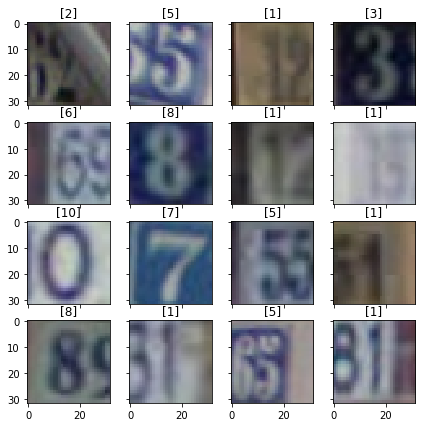

In [6]:
# Display one of the images
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(7,7))
idx = np.random.randint(train_X.shape[0], size=(4,4))
for i, ns in enumerate(idx):
    for j, n in enumerate(ns):
        ax[i][j].imshow(train_X[n])
        ax[i][j].set_title(str(train_y[n]))
plt.show()

In [7]:
# Convert the training and test images to grayscale
train_X_grey = np.mean(train_X, axis=3)
test_X_grey = np.mean(test_X, axis=3)

print(f"train\n\tX shape:\t{train_X_grey.shape}")
print(f"test\n\tX shape:\t{test_X_grey.shape}")

train
	X shape:	(73257, 32, 32)
test
	X shape:	(26032, 32, 32)


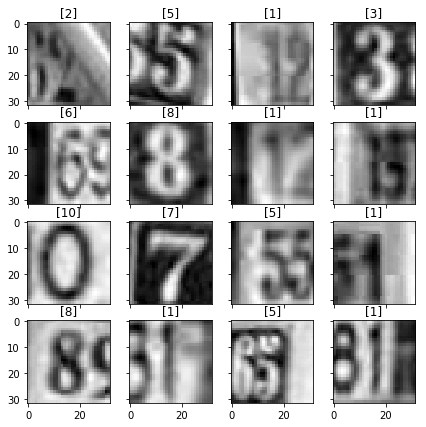

In [8]:
# Display one of the images
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(7,7))
for i, ns in enumerate(idx):
    for j, n in enumerate(ns):
        ax[i][j].imshow(train_X_grey[n], cmap=plt.get_cmap("gray"))
        ax[i][j].set_title(str(train_y[n]))
plt.show()

In [9]:
# Add a dimention for color channel
train_X_grey = train_X_grey[..., np.newaxis]
test_X_grey = test_X_grey[..., np.newaxis]

# Change label shape to be sparse
train_y_sparse = tf.keras.utils.to_categorical(train_y-1)
test_y_sparse = tf.keras.utils.to_categorical(test_y-1)

print(f"train\n\tX shape:\t{train_X_grey.shape}")
print(f"\ty shape:\t{train_y_sparse.shape}")
print(f"test\n\tX shape:\t{test_X_grey.shape}")
print(f"\ty shape:\t{test_y_sparse.shape}")

train
	X shape:	(73257, 32, 32, 1)
	y shape:	(73257, 10)
test
	X shape:	(26032, 32, 32, 1)
	y shape:	(26032, 10)


## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [30]:
wd = 1e-5
rate = 0.3

model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [31]:
model_mlp.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
)
model_mlp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 10)               

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
)

checkpoint_best_mlp = tf.keras.callbacks.ModelCheckpoint(
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    frequency='epoch',
    filepath='checkpoints_best_mlp/checkpoint',
    verbose=1
)
checkpoint_best_cnn = tf.keras.callbacks.ModelCheckpoint(
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    frequency='epoch',
    filepath='checkpoints_best_cnn/checkpoint',
    verbose=1
)

callbacks_mlp = [early_stopping, checkpoint_best_mlp]
callbacks_cnn = [early_stopping, checkpoint_best_cnn]

In [33]:
history = model_mlp.fit(train_X_grey, train_y_sparse, epochs=15, validation_split=0.2, callbacks=callbacks_mlp)

Train on 62268 samples, validate on 10989 samples
Epoch 1/20
62176/62268 [============================>.] - ETA: 0s - loss: 2.6462 - accuracy: 0.2887
Epoch 00001: val_loss improved from inf to 1.54235, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 68s 1ms/sample - loss: 2.6442 - accuracy: 0.2890 - val_loss: 1.5423 - val_accuracy: 0.4940
Epoch 2/20
62208/62268 [============================>.] - ETA: 0s - loss: 1.4537 - accuracy: 0.5212
Epoch 00002: val_loss improved from 1.54235 to 1.48681, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 66s 1ms/sample - loss: 1.4538 - accuracy: 0.5211 - val_loss: 1.4868 - val_accuracy: 0.4949
Epoch 3/20
62176/62268 [============================>.] - ETA: 0s - loss: 1.3288 - accuracy: 0.5741
Epoch 00003: val_loss improved from 1.48681 to 1.20548, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 65s 1ms/sample -

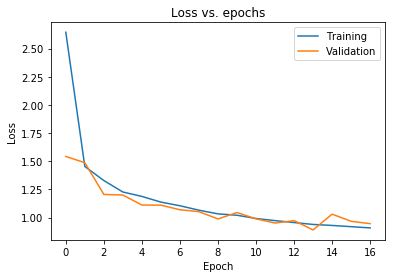

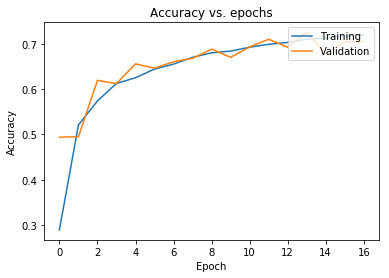

In [34]:
# Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [37]:
model_mlp.evaluate(test_X_grey, test_y_sparse, verbose=2)

26032/1 - 5s - loss: 0.9948 - accuracy: 0.6899


[1.0297147772322421, 0.6898817]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [54]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=train_X_grey[0].shape, padding='SAME', name='conv_1'),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='SAME', name='conv_2'),
    tf.keras.layers.MaxPool2D(8,8, name='pool_1'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(10, activation='softmax', name='dense_2'),
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 8)           32        
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)              

In [51]:
history = model_cnn.fit(train_X_grey, train_y_sparse, epochs=15, validation_split=0.20, callbacks=callbacks_cnn)

Train on 62268 samples, validate on 10989 samples
Epoch 1/20
62240/62268 [============================>.] - ETA: 0s - loss: 1.3285 - accuracy: 0.5541
Epoch 00001: val_loss improved from 0.89068 to 0.77059, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 390s 6ms/sample - loss: 1.3285 - accuracy: 0.5542 - val_loss: 0.7706 - val_accuracy: 0.7557
Epoch 2/20
62240/62268 [============================>.] - ETA: 0s - loss: 0.8179 - accuracy: 0.7424
Epoch 00002: val_loss improved from 0.77059 to 0.66002, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 372s 6ms/sample - loss: 0.8178 - accuracy: 0.7424 - val_loss: 0.6600 - val_accuracy: 0.7960
Epoch 3/20
62240/62268 [============================>.] - ETA: 0s - loss: 0.7284 - accuracy: 0.7718
Epoch 00003: val_loss improved from 0.66002 to 0.65889, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 383s 6ms/s

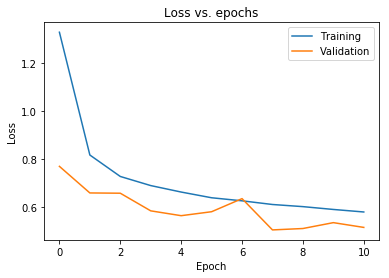

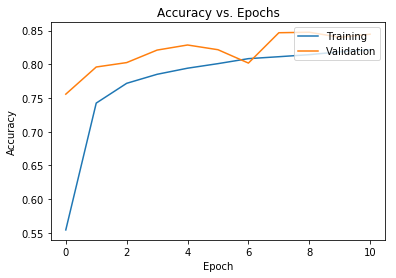

In [53]:
# Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [58]:
model_cnn.evaluate(test_X_grey, test_y_sparse, verbose=2)

26032/1 - 46s - loss: 72.5836 - accuracy: 0.1574


[72.31027291080449, 0.15742163]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [57]:
! ls checkpoints_best_only/checkpoint

checkpoints_best_only/checkpoint
